Directory found: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary
Found 12 Parquet files.
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-1.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-10.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-11.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-12.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-2.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-3.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-4.parquet
Loading file: D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary\trip_records\2023-

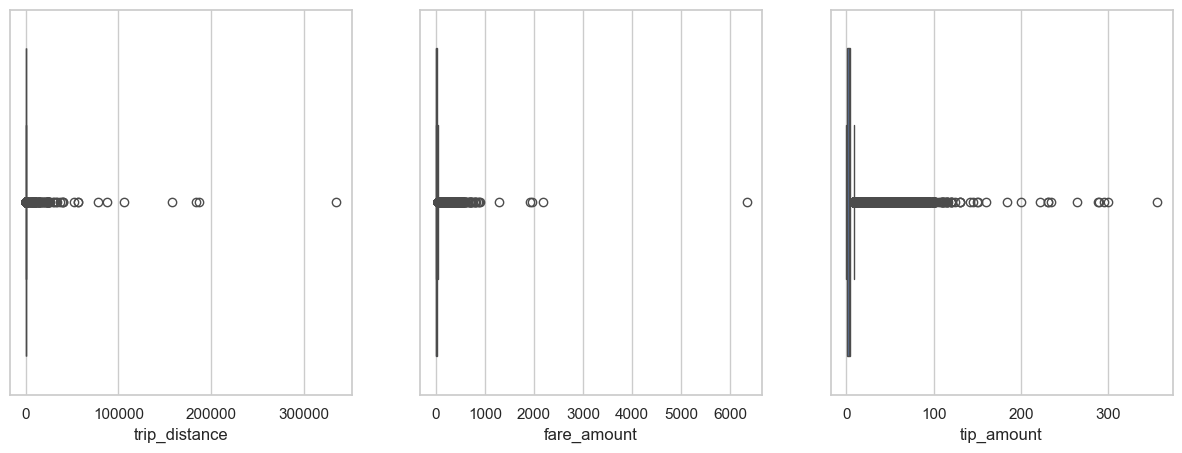

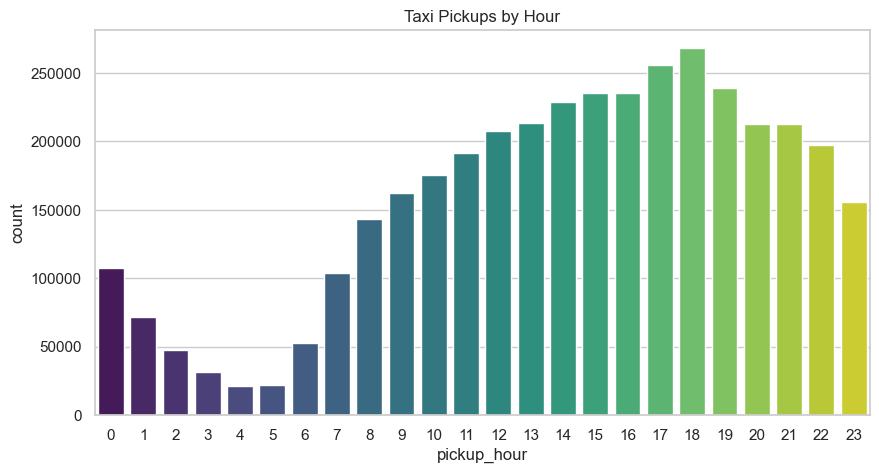

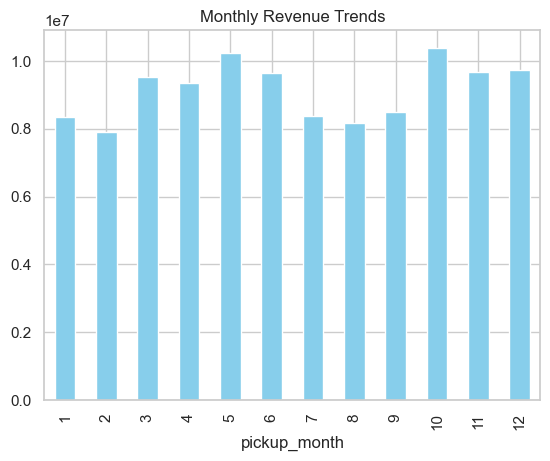

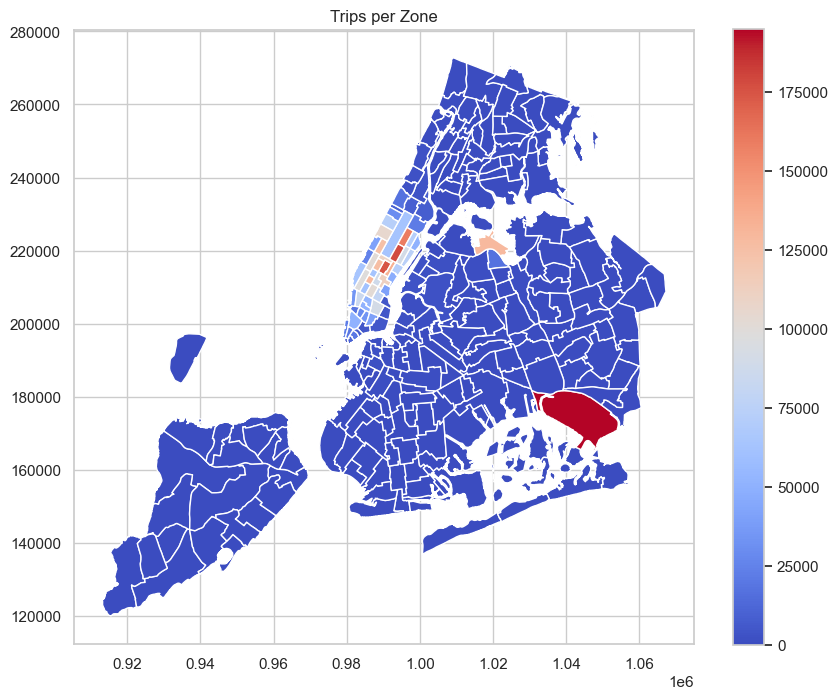

Recommendations:
- Optimize dispatching for peak hours (morning 7-9 AM, evening 5-7 PM).
- Position cabs near busy zones based on hourly trends.
- Adjust pricing dynamically for high-demand areas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import warnings
import glob

# Suppress warnings
warnings.filterwarnings("ignore")

# Set visualization styles
sns.set(style="whitegrid")

# Load dataset (Modify path accordingly)
data_dir = r"D:\Study\UpGrad\AIML\Exercises\Assignment-1_EDA\DatasetsandDictionary"  # Use raw string to avoid escape sequence issues

# Check if directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory not found: {data_dir}")
else:
    print(f"Directory found: {data_dir}")

# Sample approach to load multiple parquet files
file_list = []
for root, _, files in os.walk(data_dir):  # Recursively search subfolders
    for file in files:
        if file.endswith(".parquet"):
            file_list.append(os.path.join(root, file))  # Get full file path

if not file_list:
    raise ValueError(f"No Parquet files found in directory: {data_dir}")
print(f"Found {len(file_list)} Parquet files.")

def load_data(file_list, sample_fraction=0.1):
    """Loads and samples data from multiple parquet files."""
    df_list = []
    for file_path in file_list:
        print(f"Loading file: {file_path}")
        
        if not os.path.exists(file_path):
            print(f"Warning: File not found - {file_path}")
            continue  # Skip missing files
        
        df = pd.read_parquet(file_path)
        df_sample = df.sample(frac=sample_fraction, random_state=42)  # Sampling
        df_list.append(df_sample)
    
    if not df_list:
        raise ValueError("No valid data loaded. Check the Parquet files.")
    
    return pd.concat(df_list, ignore_index=True)

# Load & sample data
df = load_data(file_list)

# Display dataset overview
print(df.info())
print(df.head())

# Data Cleaning
# Standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Handle missing values
missing_values = df.isnull().sum() / len(df) * 100
print("Missing Value Percentages:\n", missing_values)

# Handle outliers in trip_distance, fare_amount, tip_amount
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x=df['trip_distance'], ax=axes[0])
sns.boxplot(x=df['fare_amount'], ax=axes[1])
sns.boxplot(x=df['tip_amount'], ax=axes[2])
plt.show()

# EDA: Distribution of trips by hour, day, and month
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
df['pickup_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month

plt.figure(figsize=(10, 5))
sns.countplot(x=df['pickup_hour'], palette='viridis')
plt.title("Taxi Pickups by Hour")
plt.show()

# Revenue Trends Analysis
monthly_revenue = df.groupby("pickup_month")['total_amount'].sum()
monthly_revenue.plot(kind='bar', title='Monthly Revenue Trends', color='skyblue')
plt.show()

# Geospatial Analysis (NYC Taxi Zones)
taxi_zones_dir = os.path.join(data_dir, "taxi_zones")
shapefile_path = os.path.join(taxi_zones_dir, "taxi_zones.shp")

if not os.path.exists(shapefile_path):
    shapefile_list = glob.glob(os.path.join(data_dir, "**", "taxi_zones.shp"), recursive=True)
    if shapefile_list:
        shapefile_path = shapefile_list[0]  # Take the first found file
    else:
        raise FileNotFoundError("Shapefile not found in the dataset directory or its subfolders.")

zones = gpd.read_file(shapefile_path)
trips_per_zone = df.groupby('pulocationid').size().reset_index(name='num_trips')
zones = zones.merge(trips_per_zone, left_on='LocationID', right_on='pulocationid', how='left').fillna(0)

zones.plot(column='num_trips', cmap='coolwarm', legend=True, figsize=(10, 8))
plt.title("Trips per Zone")
plt.show()

# Conclusion and Recommendations
print("Recommendations:")
print("- Optimize dispatching for peak hours (morning 7-9 AM, evening 5-7 PM).")
print("- Position cabs near busy zones based on hourly trends.")
print("- Adjust pricing dynamically for high-demand areas.")